# Fitting a model to data

In this tutorial we will see how one can use ``pocoMC`` to fit a model to some data.

The model that we will use is a *cosine* oscillation of frequency $\omega$ and phase $\phi$ with a linearly-evolving amplitude:

$$
x(t) = (A + B\,t) \, cos(\omega\,t + \phi)
$$

As usually, we begin by importing ``numpy``, ``matplotlib`` and of course ``pocoMC``:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

## Defining the model and generating the data

We define the model as function that accepts an array of parameters and an array of the time instances. We then use the same model to
generate some data by specifying the *true* parameters (these will be what we will attempt to estimate), a noise level ``sigma`` and the
time instances ``t``. Finally, we plot the data along with the model that we used to generate them.

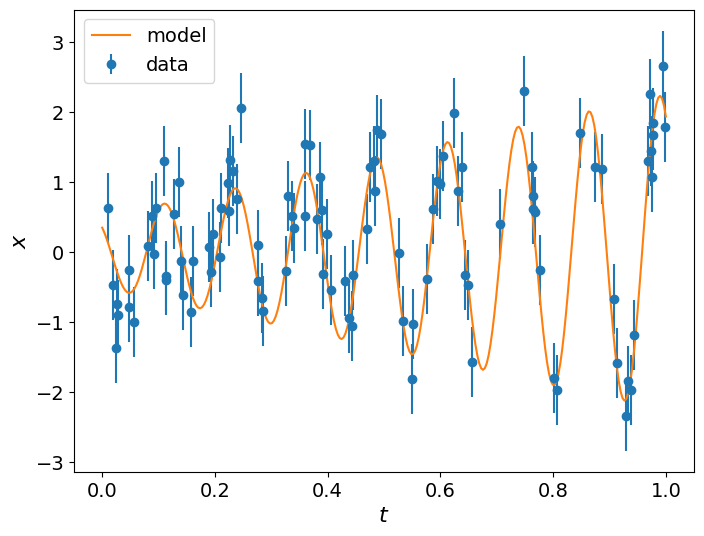

In [2]:
# Model with linearly-evolving amplitude
def model(params, t):
    A, B, omega, phi, = params
    return (A + B * t) * np.cos(omega * t + phi)

# True parameters
params_true = np.array([0.5, 1.75, 50.0, 0.8])

# Time instances corresponding to available data
t = np.random.uniform(0.0, 1.0, 100)
idx = np.argsort(t)
t = t[idx]

# Standard deviation of Gaussian noise of the data
sigma = 0.5

# Simulated data
data = np.random.normal(model(params_true, t), sigma) 

# Time range used for plotting only
t_range = np.linspace(0.0, 1.0, 300)

# Figure
plt.figure(figsize=(8,6))
plt.errorbar(t, data, yerr=sigma, fmt="o", label='data')
plt.plot(t_range, model(params_true, t_range), label='model')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Prior probability distribution

We first need to define the prior distribution for our problem.

We will assume that the prior for each parameter (e.g., A, B, omega, phi) is uniform. This can be
specified using the ``unif`` class from ``scipy.stats``. ``unif`` accepts two arguments, the lower
bound ``L`` and the width of the prior ``W``, where the width ``W`` is simply the difference of 
the upper bound ``U`` from the lower bound ``L``, that is ``W=U-L``. 

We can then combine the independent priors for each parameter into a joint prior distribution using
the ``Prior`` class object of ``pocoMC``.

In [3]:
from scipy.stats import uniform

prior = pc.Prior([
    uniform(-5.0, 10.0), # A in [-5, 5]
    uniform(-5.0, 10.0), # B in [-5, 5]
    uniform(10.0, 100.0), # omega in [10, 100]
    uniform(0.0, np.pi), # phi in [0, pi]
])

Any ``scipy.stats`` probability distribution object can be in the ``Prior``. For instance, ``prior = Prior([uniform(0,1), norm(0, 1)])``
is a 2-dimensional prior probability distribution where the first parameter is uniformly distributed in ``[0,1]`` and the second is
normally/Gaussianly distributed with mean ``0`` and standard deviation ``1``.

## Log-likelihood function

We then define the log-likelihood function

In [4]:
# Log-likelihood functions
def log_like(params, t, data, sigma):
    m = model(params, t)
    diff = m - data
    return -0.5 * np.dot(diff, diff) / sigma**2.0

## Initialising and running Preconditioned Monte Carlo

We initialise the sampler by providing:
- the log-likelihood function ``log_like``,
- the prior probability object ``prior``,
- a list ``likelihood_args`` with the additional arguments that enter in the log-likelihood function ``likelihood``,

In [5]:
# Sampler initialisation
sampler = pc.Sampler(prior=prior,
                     likelihood=log_like,
                     likelihood_args=[t, data, sigma],
                     )

# Run sampler
sampler.run()

Iter: 38it [03:48,  6.02s/it, calls=5e+4, beta=1, logZ=-57.3, ESS=4.97e+3, accept=0.865, steps=1, logp=-47.2, efficiency=0.832]       


## Results

We can get the results from the ``posterior()`` and ``evidence()`` methods.

### Posterior samples

In [6]:
samples, weights, logl, logp = sampler.posterior()

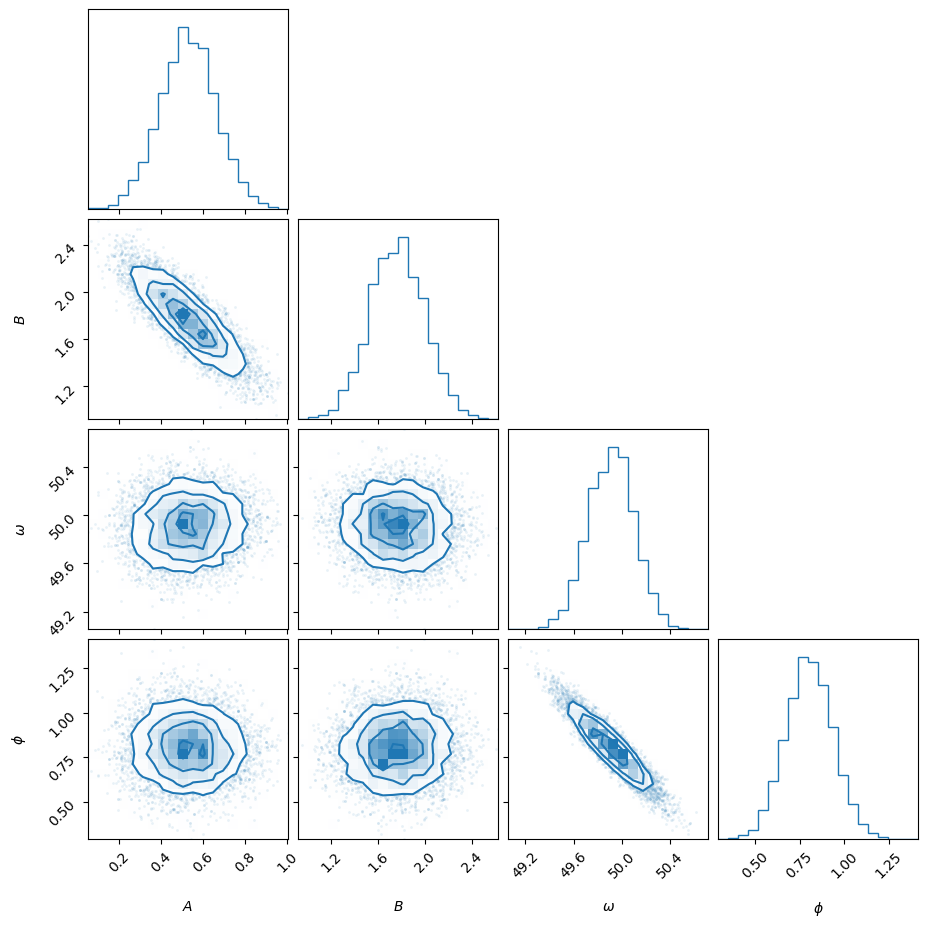

In [7]:
import corner

fig = corner.corner(samples, weights=weights, labels=[r'$A$', r'$B$', r'$\omega$', r'$\phi$'], color='C0')
plt.show()

You can also resample the samples (i.e., make them have equal weights). The resampled points can be used just like you would do with MCMC samples.

In [9]:
resampled_points, _, _ = sampler.posterior(resample=True)

We can also compute any expectation values we want using the posterior samples.

In [10]:
print('Mean values = ', np.mean(resampled_points, axis=0))
print('Standard deviation values = ', np.std(resampled_points, axis=0))

Mean values =  [ 0.52903128  1.76190206 49.91035108  0.80430747]
Standard deviation values =  [0.13387134 0.23280674 0.18780775 0.13275501]


### Bayesian Model Evidence or Marginal Likelihood

To compute the estimate of the marginal likelihood ``log Z`` and its standard deviation, you can use the ``evidence()`` method.

In [11]:
logz, logz_err = sampler.evidence()

print("logZ =", logz, "+-", logz_err)

logZ = -56.454248481584564 +- 0.027575420864617416


## Posterior predictive check

Finally, we can perform some Posterior Predictive Checks to assess the predictive performance of our fit.

The distribution that reflects the probability of new data given the current data is the *posterior predictive distribution*:

$$
P(D_{new}|D) = \int_{\Theta} P(D_{new}|\theta,D)P(\theta|D)d\theta
$$
where $P(D_{new}|\theta,D) = P(D_{new}|\theta)$ assuming $D_{new}$ is independent of $D$.

The easiest way to sample from the posterior predictive distribution is to use the posterior samples that we have already to generate the new data.

In [12]:
sim_data = []

for params in resampled_points:
    sim_data.append(np.random.normal(model(params, t_range), sigma))

sim_data = np.array(sim_data)

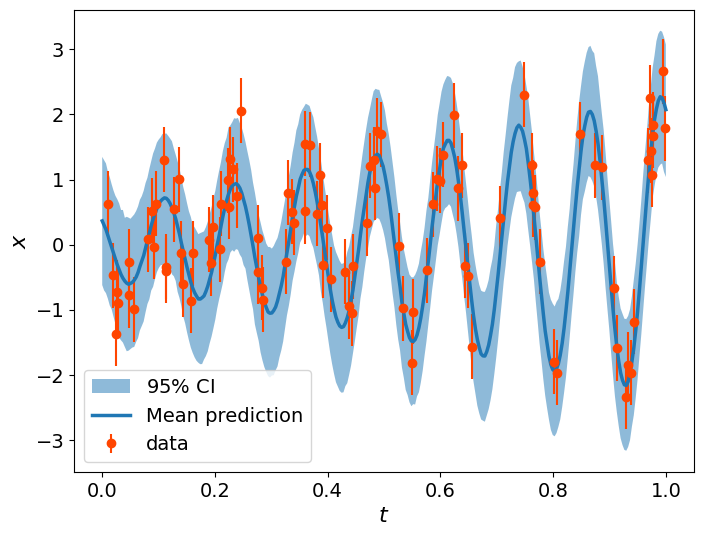

In [13]:
plt.figure(figsize=(8,6))
plt.fill_between(t_range, np.percentile(sim_data,2.5,axis=0),np.percentile(sim_data,97.5,axis=0),alpha=0.5, label=r'$95\%$ CI')
plt.errorbar(x=t, y=data, yerr=sigma, marker='o', ls=' ', color='orangered', label='data')
plt.plot(t_range, np.mean(sim_data, axis=0), lw=2.5, label='Mean prediction')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$x$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()